# Genomics and High Dimensionality

In [10]:
%matplotlib inline
%load_ext memory_profiler
import numpy as np
from scipy import sparse
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import time
import pandas as pd
import pickle
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib as mpl
from yellowbrick.style import rcmod
from scipy.stats import spearmanr
from memory_profiler import profile

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [11]:
# Yellowbrick changes the plotting settings, reset to default here
rcmod.reset_orig()

# Case 1, cell sampling and genes

In [12]:
X = np.load("data/p1/X.npy")
y = np.load("data/p1/y.npy")

In [13]:
# 511 cells, 45768 genes
print(X.shape)

(511, 45768)


In [14]:
# Largest entry of first column
np.max(X[:,0])

11.941397591320595

2. Log transform

In [15]:
# Log 
X_log = np.log2(X + 1)

In [16]:
# Largest entry of first column
print(np.max(X_log[:,0]))

3.6939215228197613


3. Full PCA, raw vs transformed data

In [17]:
%%timeit -n 1 -r 1
%%memit -r 1
pca = PCA().fit(X)
pca_log = PCA().fit(X_log)

peak memory: 1324.13 MiB, increment: 883.46 MiB
13.8 s Â± 0 ns per loop (mean Â± std. dev. of 1 run, 1 loop each)


In [18]:
# Percentage of variance explained by first component
print("First component raw:", pca.explained_variance_ratio_[0])
print("First component log:", pca_log.explained_variance_ratio_[0])

First component raw: 0.42779670983572665
First component log: 0.13887564870826177


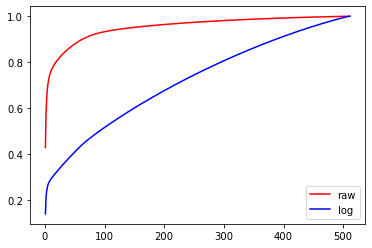

In [19]:
# Cumulative variance explained plots
plt.plot(range(1, X.shape[0]+1), np.cumsum(pca.explained_variance_ratio_), color="red", label="raw")
plt.plot(range(1, X.shape[0]+1), np.cumsum(pca_log.explained_variance_ratio_), color="blue", label="log")
plt.legend()
plt.show()

In [20]:
# 85% variance cutoffs
print("Raw:", np.where(np.cumsum(pca.explained_variance_ratio_) >= .85)[0][0] + 1)
print("Log:", np.where(np.cumsum(pca_log.explained_variance_ratio_) >= .85)[0][0] + 1)

Raw: 36
Log: 339


Remember that we want to find genes that can differentiate between cells, even if the genes are not expressed in many cells and/or have low levels of expression. For example, if a particular gene has $0$ expression for $80$ cells and $0.2$ expression for $20$ cells, that would contribute much less to the variance than a gene with $0$ expression for $50$ cells and $0.8$ expression for $50$ cells. While the latter gene might just differentiate between neuron vs non-neuron (for example),  the former gene might differentiate between specific cell types.  But the variances differ greatly and we don't want to make the conclusion that the latter gene is sufficient for explaining the variation between cells in the data.

4. Plotting without visualization techniques

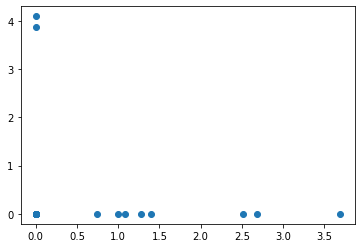

In [21]:
# Nothing informative!
plt.scatter(X_log[:,0],X_log[:,1])

5. PCA visualization

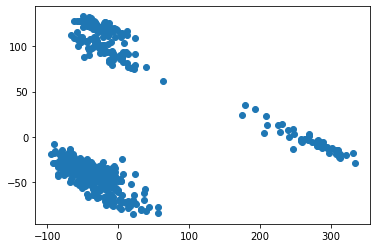

In [29]:
# Three visually distinct clusters. Could potentially argue for 4 or 5 as well, but these are not well-separated
z = pca_log.transform(X_log)
plt.scatter(z[:,0],z[:,1])

6. MDS (sklearn version is nonlinear)

2124519600.002637


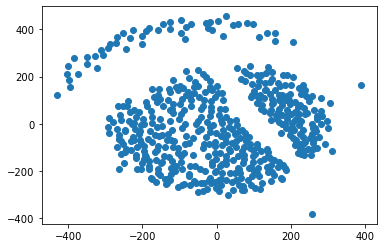

In [48]:
#Since there is randomization in the initial state, run this multiple times and use the result with the best objective function value.  (Also be aware that some initializations can give you suboptimal local minima for both MDS and T-SNE algorithms).
# We still see 3 distinct clusters.  
mds_class=MDS(n_components=2)
mds=mds_class.fit_transform(X_log)
print(mds_class.stress_)
plt.scatter(mds[:,0],mds[:,1])

7. T-SNE

0.4181838035583496


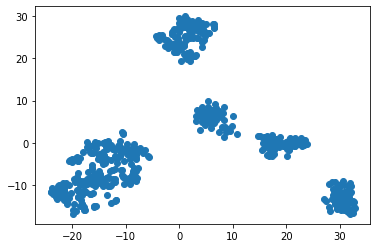

In [44]:
# Emergence of at least 5 clusters. 
#Since there is randomization in the initial state, run this multiple times and use the result with the best objective function value.  (Also be aware that some initializations can give you suboptimal local minima for both MDS and T-SNE algorithms).

z_tsne_class = TSNE(n_components=2,perplexity=40)
z_tsne=z_tsne_class.fit_transform(z[:,0:50])
print(z_tsne_class.kl_divergence_)
plt.scatter(z_tsne[:,0],z_tsne[:,1])


8. K-Means

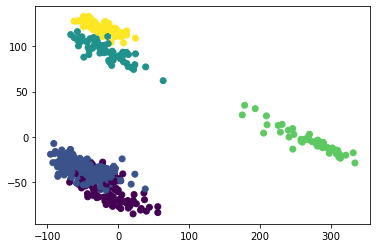

In [49]:
# 5 clusters: PCA plot
kmeans = KMeans(5, tol=1e-6)
kmeans.fit(z[:,0:50])
plt.scatter(z[:,0],z[:,1], c=kmeans.labels_)

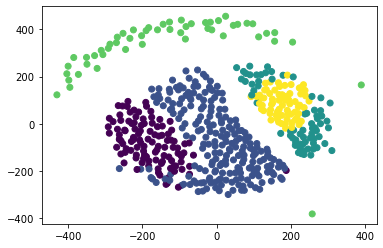

In [50]:
# 5 clusters: MDA with K means plot
plt.scatter(mds[:,0],mds[:,1],c=kmeans.labels_)

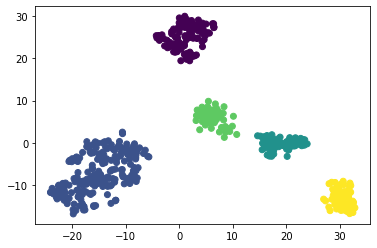

In [51]:
# T-SNE plot
plt.scatter(z_tsne[:,0],z_tsne[:,1], c=kmeans.labels_)

9. Elbow method.

Num clusters 2 Inertia: 9520809.578746
Num clusters 3 Inertia: 7257882.201193228
Num clusters 4 Inertia: 6202929.841899466
Num clusters 5 Inertia: 5801585.180913827
Num clusters 6 Inertia: 5561682.44813587
Num clusters 7 Inertia: 5383627.3853926575
Num clusters 8 Inertia: 5261084.906517991
Num clusters 9 Inertia: 5170301.96159251


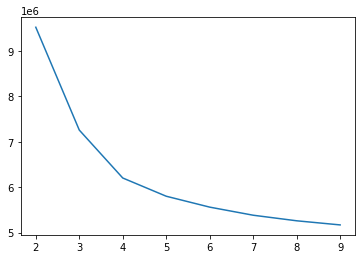

In [52]:
# Would select 3, 4, or 5 clusters
all_kmeans = [i for i in range(8)]
for i in range(8):
    cur_kmeans = KMeans(i+2)
    cur_kmeans.fit(z[:,0:50])
    print("Num clusters", i+2, "Inertia:", cur_kmeans.inertia_)
    all_kmeans[i] = cur_kmeans
plt.plot([i+2 for i in range(8)], [all_kmeans[i].inertia_ for i in range(8)])

10. Hierarchical clustering: Dendrogram in R script

11. MDS on cluster means. Confirms 3 groups, one with 1 cluster and two with 2 clusters each. Accurate representation of distances - one cluster is far away from others, indicating a different type of cell. But T-SNE consistently puts it in the middle of the plot.

In [53]:
# MDS on kmeans cluster means
cmeans = np.zeros((5,X_log.shape[1]))
for c in range(5):
    cmeans[c] = np.mean(X_log[np.where(kmeans.labels_==c)[0]],axis=0)

breaking at iteration 110 with stress 6342.498506003656
breaking at iteration 101 with stress 6342.5067096772655
breaking at iteration 81 with stress 6080.333405580436
breaking at iteration 48 with stress 6080.516826332532


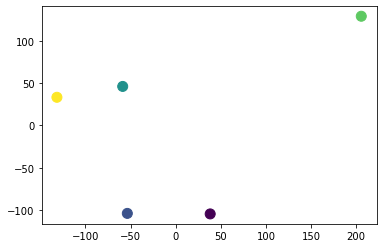

In [58]:
mds = MDS(n_components=2,verbose=1,eps=1e-5)
mds.fit(cmeans)
plt.scatter(mds.embedding_[:,0],mds.embedding_[:,1],c=[0,1,2,3,4],s=100)

In MDS, we see one group with 1 cluster mean and two groups with 2 cluster means each. MDS aim to respresent distances accurately.  The one cluster that far away from the other indicates a different type of cell.

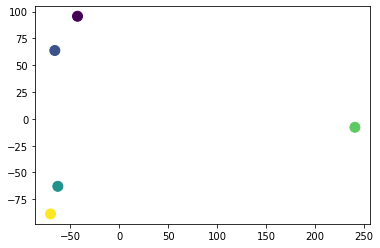

In [55]:
# PCA on cluster means
z_means = PCA(2).fit_transform(cmeans)
plt.scatter(z_means[:,0],z_means[:,1],c=[0,1,2,3,4],s=100)

Similarly, in PCA,  we again see one group with 1 cluster mean and two groups with 2 cluster means each. PCA is a linear projection, hence the distances in the PC directions are preserved.  The one cluster that far away from the other indicates a different type of cell.

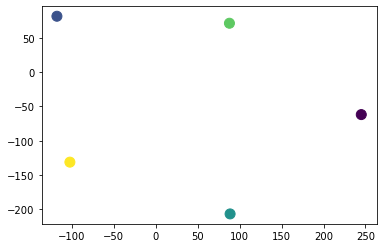

In [26]:
# Emergence of at least 5 clusters. 
z_means_tsne = TSNE(n_components=2,perplexity=40).fit_transform(cmeans)
plt.scatter(z_means_tsne[:,0],z_means_tsne[:,1],c=[0,1,2,3,4],s=100)

T-SNE does not represent distances accurately.  The hierarchical structure of the 5 clusters falling into 3 groups are lost.   (on the other hand, we saw that the 5 clusters are well separated.)

12. PCA/T-SNE on Raw Data

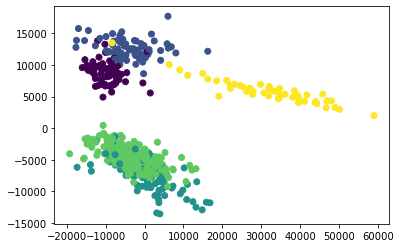

In [59]:
pca = PCA(50).fit(X)
z = pca.transform(X)
plt.scatter(z[:,0],z[:,1],c=y)

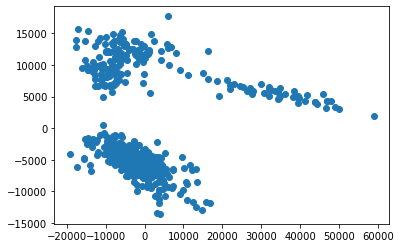

In [60]:
pca = PCA(50).fit(X)
z = pca.transform(X)
plt.scatter(z[:,0],z[:,1])

breaking at iteration 253 with stress 2184710857829.9453


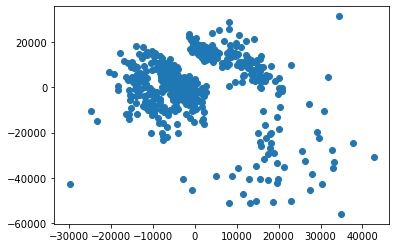

In [61]:
mds = MDS(n_components=2,verbose=1,eps=1e-5)
mds.fit(z[:,0:50])
plt.scatter(mds.embedding_[:,0],mds.embedding_[:,1])

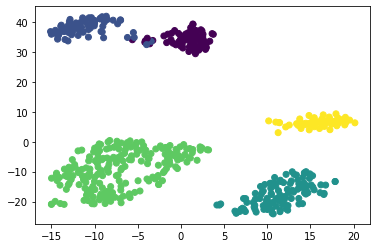

In [62]:
z_tsne = TSNE(n_components=2,perplexity=40).fit_transform(z[:,0:50])
plt.scatter(z_tsne[:,0],z_tsne[:,1],c=y)

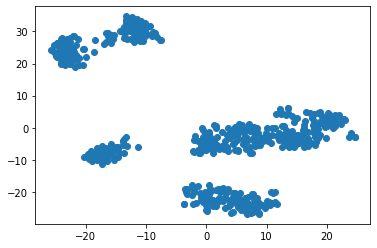

In [63]:
z_tsne = TSNE(n_components=2,perplexity=40).fit_transform(z[:,0:50])
plt.scatter(z_tsne[:,0],z_tsne[:,1])

The log transformed data produced more clearly defined clusters. This typically happens for this type of data.  